In [1]:
%load_ext autoreload
%autoreload 2

# Probabilistyczne Modele Grafowe:
## 9. Aspekty uczenia i ewaluacji Bayesowskich modeli uczenia maszynowego
#### Tomasz Kajdanowicz, Piotr Bielak, Maciej Falkiewicz, Piotr Zieliński
#### Katedra Inteligencji Obliczeniowej - Politechnika Wrocławska

### Prezentacja powstała na podstawie następujących materiałów źródłowych:
- [Christopher M. Bishop.Pattern Recognition and Machine Learning. Springer, 2006](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) Chapter 3.5 The Evidence Approximation
- Notatki autorstwa Johna T. Whelana do kursu [Bayesian Model Evaluation](https://ccrgpages.rit.edu/~whelan/courses/2017_1sp_STAT_489/) - [Part Two: Bayesian Model Evaluation](https://ccrgpages.rit.edu/~whelan/courses/2017_1sp_STAT_489/notes_models.pdf)
- Blog Post autorstwa [Eduardo Coronado Sroka](https://ecoronado92.github.io/) - [Evaluating Bayesian Mixed Models in R/Python](https://towardsdatascience.com/evaluating-bayesian-mixed-models-in-r-python-27d344a03016)

### Spis Treści
- Wstęp
- Dane i modele
- Ewaluacja modelu
   - Posterior Predictive Checks:
      - Rozkład posterior
      - Statystyki testowe
      - Probability Integral Transform
- Porównywanie modeli
   - Bayes factors
   - Expected Log Predictive Density

# Wstęp

### Aspekty uczenia i ewaluacji Bayesowskich modeli
- Ewaluacja modelu -- Model Checking
- Porównywanie modeli -- Model Comparision
- Wybór hiper-parametrów (poza zakresem dzisiejszego wykładu)
   - Empirical Bayes / Evidence Approximation / Evidence Maximization
   - Expectation-Maximization
   - Aproksymacje *evidence* dla konkretnych modeli -- np. Laplace approximation dla Bayesian Linear Regression ze sprzężonymi priorami ([Christopher M. Bishop.Pattern Recognition and Machine Learning. Springer, 2006](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) Section 4.4)

### Modelowanie: Cel
- Osiagniecie jak najlepszych wartosci metryk? NIE
- Zbudowanie modelu, który umozliwi dokladna predykcje *przyszlosci* - tzw, **generalizacja**? TAK, ale nie tylko
- Identyfikacja sytuacji, w ktorych model nie dziala i zrozumienie czemu? TAK
- Zrozumienie analizowanego problemu i dobór odpowuednich narzędzi? TAK

### Modelowanie: Z czego składa się model?
1. **Wstępna wiedza**:
   - *background information* na temat zjawiska - pozwala kwantyfikować przekonanie (prawdopobienstwo) na temat poprawnosci stwierdzenia. Moze sie miedzy innymi wyrazac jako:
      - Wybor parametryczna postać modelu (np. Bayesian Linear Regression) - stąd wiem jak obliczać likelihood, rozkład posterior parametrów, rozkład predykcyjny, itp.
      - Przekonanie co do poprawnosci roznych postaci parametrycznych
      - Przekonanie na temat poprawności rozkładu prior parametrow
   - Rozkład prior dla parametrów modelu
     
     W tym punkcie zawiera się wiedza o parametrycznej postaci priora (rodzina rozkładów) oraz jej konkretnej parametryzacji. Prior może być *informative* bądź *uninformative*. Może tez nie byc pelnoprawnym rozkladem prawdopodobienstwa i wtedy mowimy, ze jest *improper*.
2. **Dane treningowe** na podstawie, których aktualizujemy wstępna wiedze

Koncept *background information* wywodzi sie z prac Richarda Coxa z 1946 roku. Chciał opracować spojny system logicznego wnioskowania. Doszedł do wniosku, ze kazde stwierdzenie ktorego prawdziwosci nie jestesmy w stanie sprawdzic "binarnie" posiada pewien poziom zaufania, ktory je darzymy. Naturalnym okazało sie ujac system w jezyku teorii prawdopobienstwa. Aby jednak zachowac spojnosc nalezy wprowadzic *background information*, które warunkuje wszystkie rozkłady. Albowiem nie ma uniwersalnej miary pewnosci stwierdzeń i kazdy ocenia ja wzgledem swojej wiedzy i doswiadczen.

Ciekawe i przystepne wprowadzenie do tematu mozna znalzc w ksiazce [Sivia, Devinderjit, and John Skilling. Data analysis: a Bayesian tutorial. OUP Oxford, 2006.](http://aprsa.villanova.edu/files/sivia.pdf).

### Model - formalnie
- $I$ - background information
- $\pmb{\theta}$ - parametry modelu
- $M$ - wiedza o rozkładzie prior
- $\mathcal{D}$ - dane

Rozkład posterior parametrów:
$$ p(\pmb{\theta}|\mathcal{D}, M, I) = \frac{p(\mathcal{D}|\pmb{\theta}, I)p(\pmb{\theta}| M, I)}{p(\mathcal{D}|M,I)}$$

Marginalized sampling distribution / *model evidence* / mariginal likelihood:
$$ p(\mathcal{D}|M,I) = \int p(\mathcal{D}|\pmb{\theta}, I)p(\pmb{\theta}| M, I)d\pmb{\theta} $$

Prawdopobienstwo posterior modelu (dla danego background information):
$$ P(M|\mathcal{D}, I) = \frac{p(\mathcal{D}|M,I) P(M|I)}{p(\mathcal{D}|I)} $$

- $P(M|I)$ - zgodnie z dotychczasowa narracja nalezaloby rozumiec ta wartosc jako relatywne przekonanie na temat poprawnosci $M$, nie badzmy jednak zbyt doslowni gdyz:
  
  *Essentially,  all  models  are  wrong,  but  some  are  useful* 
  
  ~George  Box w Box & Draper,Empirical Model-Building and Response Surfaces(Wi-ley.  1987)
- $p(\mathcal{D}|I)$ - ten wyraz jest problematyczny poniewaz aby go obliczyc musimy znac *wszystkie* modele (oznaczmy ich zbiór jako $\{M_i\}$) i ich prawdopobienstwa prior:
   $$ p(\mathcal{D}|I) = \sum p(\mathcal{D}|M_i, I) P(M_i|I) $$

Powrocimy do tych zagadnien w dalszej czesci tego wykladu.

# Dane i modele

### Generowanie danych
Aby przedstawic dzialanie omawianych metod w praktyce, wygenerujemy zbior danych z nastepujacego modelu:

$$ y = $$

Dopasujemy do nich nastepujace modele:
1. 
2. 

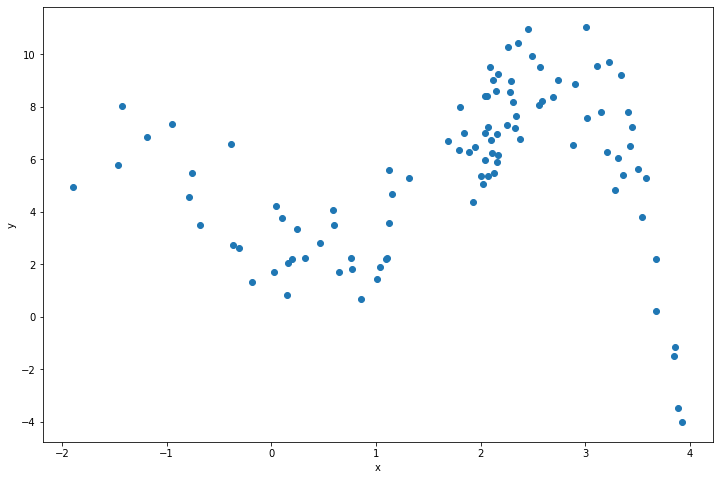

In [2]:
from src.data import sample_data, plot_data
data = sample_data()
plot_data(data)

Nanieśmy wykres funkcji na chmure danych.

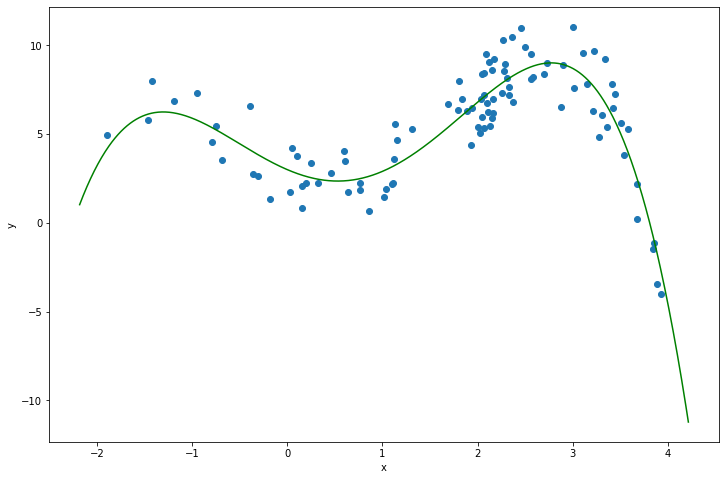

In [3]:
plot_data(data, plot_fun=True)

### Przygotowanie modeli

In [4]:
from src.models import get_model_1, get_model_2, get_model_3

model_1, x_1 = get_model_1(data)
model_2, x_2 = get_model_2(data)
model_3, x_3 = get_model_3(data)

### Model 1

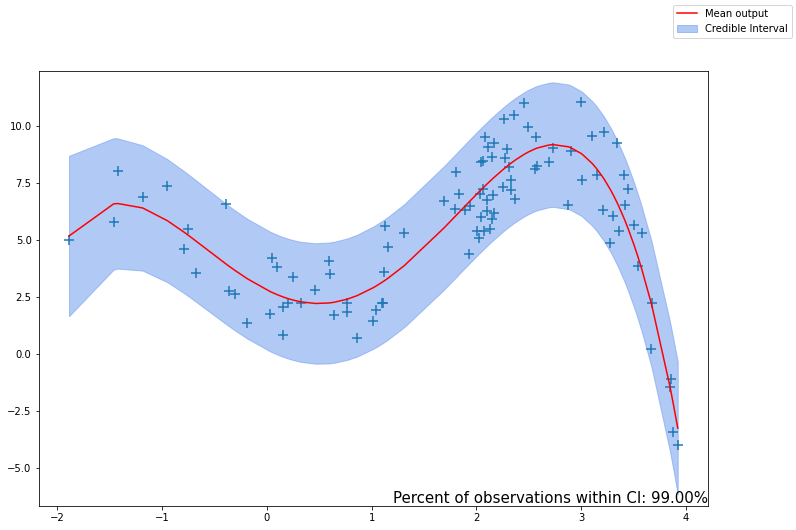

Prawdziwe wartosci wspolczynnikow: [-2.3, 1.7, 0.8, -0.3]
Srednia rozkladu wspolczynnikow w modelu: [-2.29809476  1.91843131  0.73984511 -0.30075207]


In [5]:
from src.vis import plot_model
from src.data import _data_coef

plot_model(model=model_1, x=x_1, y=data[1])
print('Prawdziwe wartosci wspolczynnikow:', _data_coef)
print('Srednia rozkladu wspolczynnikow w modelu:', model_1.mean)

### Model 2

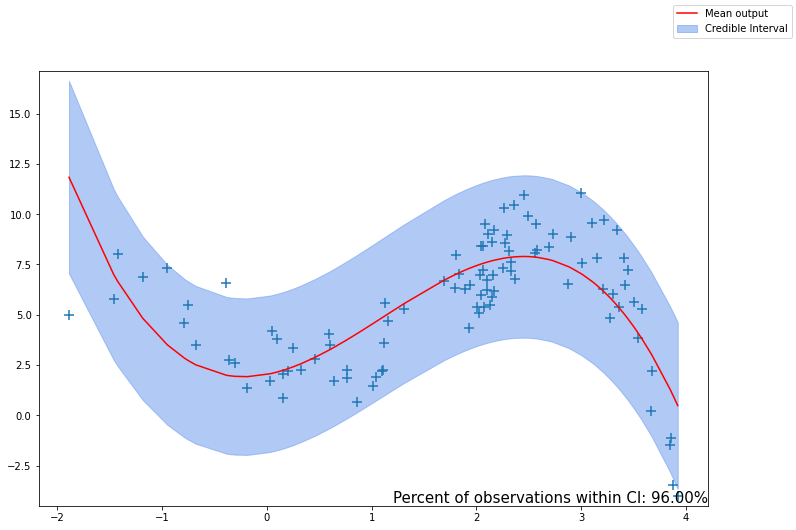

Prawdziwe wartosci wspolczynnikow: [-2.3, 1.7, 0.8, -0.3]
Srednia rozkladu wspolczynnikow w modelu: [ 1.01351343  2.09769487 -0.62625004]


In [6]:
from src.vis import plot_model

plot_model(model=model_2, x=x_2, y=data[1])
print('Prawdziwe wartosci wspolczynnikow:', _data_coef)
print('Srednia rozkladu wspolczynnikow w modelu:', model_2.mean)

### Model 3

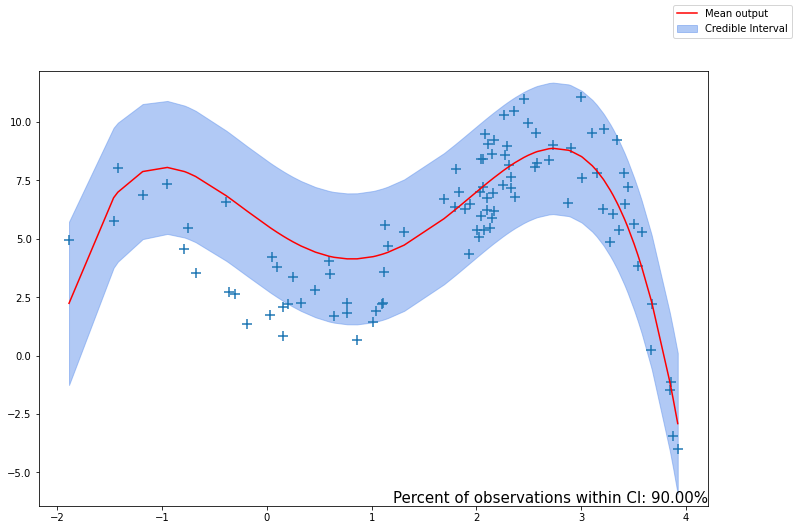

Prawdziwe wartosci wspolczynnikow: [-2.3, 1.7, 0.8, -0.3]
Srednia rozkladu wspolczynnikow w modelu: [-3.11458183  0.91948892  1.19422843 -0.34837448]


In [7]:
from src.vis import plot_model

plot_model(model=model_3, x=x_3, y=data[1])
print('Prawdziwe wartosci wspolczynnikow:', _data_coef)
print('Srednia rozkladu wspolczynnikow w modelu:', model_3.mean)

# Ewaluacja modelu
## Posterior Predictive Checks
### Rozkład posterior

### Klasyczna ewaluacja:
- Obliczenie metryk:
   - klasyfikacja:
      - wszystko na podstawie confusion matrix - brak informacji o niepewnosci modelu
      - ROC / PRC - niepewnosc wylacznie w predykcji, ale nie w parametrach modelu
   - regresja:
      - wszelkie *Error* - jaki dobrać, srednia z danych, brak informacji o niepewnosci modelu
- Q-Q plot dla rezyduów (dla wybranych modeli) - załozenia zadko kiedy sa spelnione
- interwały (zbiory) ufnosci i predykcyjne (dla wybranych modeli) - niepewnosc wylacznie w predykcji, ale nie w parametrach modelu

Aby stosowac dla modeli Bayesowskich nalezy wybrac MAP z rozkładu predykcyjnego / wielokrotnie realizowac rozklad predykcyjny.

### Bayesowska ewaluacja
W centrum Bayesowskiego podejscia do ewaluacji modeli probabilistycznych lezy fakt, ze dane obserwowane (rzeczywiste) powinny byc wysoce prawdopobne w danym modelu dopasowanym na tych danych (badz innej próbki z tego samego procesu generujacego).

Rozkład posterior predictive:

$$ p(\tilde{y}|y) = \int p(\tilde{y}|\pmb{\theta}) p(\pmb{\theta}|y) d \pmb{\theta}, $$
co w naszej, bardziej bezposredniej notacji zapiszemy jako
$$ p(\tilde{y}|y, M, I) = \int p(\tilde{y}|\pmb{\theta}, I) p(\pmb{\theta}|y, M, I) d \pmb{\theta}. $$

Ale jak obliczyc ta calke? Zamiast probowac to robic, wykorzystamy metode Monte Carlo i dla zadanego rozmiaru próbki $S$ wylosujemy realizacje parametrow z rozkladu posterior, a nastepnie probki z rozkladu predykcyjnego.

### Graficzne porównanie rozkładu posterior predictive


# Ewaluacja modelu
## Statystyki testowe

### Statystyki testowe
Graficzne porównanie rozkładów empirycznych daje nam pewna wstepna intuicje na temat dopasowania modelu, ale nie jest mozliwym wyznaczyc granice gdy jest ono zbyt slabe.

W tym celu mozemy wykorzystac statystyki testowe $T(X)$

# Ewaluacja modelu
## Probability Integral Transform

# Porównywanie modeli
## Bayes factors

# Porównywanie modeli
## Expected Log Predictive Density